# Ch8 Dimensionality Reduction

**차원의 저주**(curse of dimensionality): 훈련 샘플 각각이 수천 심지어 수백만 개의 특성을 가지고 있어 훈련을 느리게 할 뿐만 아니라 좋은 솔루션을 찾기 어렵게 만듦.

-> 이는 주로 특성 수를 크게 줄여서 불가능한 문제를 가능한 범위로 변경

주의) 차원을 축소시키면 일부 정보가 유실. 훈련 속도가 빨라질 수는 있지만 시스템의 성능이 조금 나빠질 수 있음. 작업 파이프라인이 조금 더 복잡하게 되고 유지 관리가 어려워짐.<br>
=> 따라서 차원 축소를 고려하기 전에 훈련이 너무 느린지 먼저 원본 데이터로 시스템을 훈련해봐야함.<br>
어떤 경우는 훈련 데이터의 차원을 축소시키면 잡음이나 불필요한 세부사항을 걸러내므로 성능을 높일 수 있음.

차원 축소는 데이터 시각화에도 유용<br>
차원 수를 둘 또는 셋으로 줄이면 고차원 훈련 세트를 하나의 압축된 그래프로 그릴 수 있고 군집 같은 시각적인 패턴을 감지해 중요한 통찰을 얻을 수 있음.

In [1]:
import pandas as pd
import numpy as np
import os

import sklearn
assert sklearn.__version__ >= "0.20"

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

## 8.1 차원의 저주

고차원은 많은 공간을 가지고 있음<br>
-> 대부분의 훈련 데이터가 서로 멀리 떨어져있음.<br>
-> 새로운 샘플도 훈련 샘플과 멀리 떨어져 있을 가능성이 높음.<br>
-> 이런 경우 예측을 위해 훨씬 많은 외삽(extrapolation)을 해야하기 때문에 저차원일 때보다 예측이 더 불안정.<br>
=> **훈련 세트의 차원이 클수록 과대적합 위험이 커짐**

## 8.2 차원 축소를 위한 접근 방법

### 8.2.1 투영

모든 훈련 샘플이 고차원 공간 안의 저차원 **부분 공간**(subspace)에 놓여 있음 => **투영** 사용!

그러나 **스위스 롤**(Swiss roll) 데이터셋처럼 부분 공간이 뒤틀리거나 휘어있기도 함. (적합x)

### 8.2.2 매니폴드 학습

d차원 매니폴드: 국부적으로 d차원 초평면으로 보일 수 있는 n차원 공간의 일부 (d < n)
2D **매니폴드**: 고차원 공간에서 휘어지거나 뒤틀린 2D 모양. e.g.) 스위스 롤: d=2, n=3

**매니폴드 학습**(manifold learning): 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링하는 식으로 작동.<br>
**매니폴드 가정**(manifold assumption) 또는 **매니폴드 가설**(manifold hypothesis): 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있음.

e.g.) 숫자 이미지를 만들 때 가능한 자유도는 아무 이미지나 생성할 때의 자유도보다 낮음. 이런 제약은 데이터셋을 저차원의 매니폴드로 압축할 수 있게 도와줌.

매니폴드 가정은 종종 암묵적으로 다른 가정과 병행. -> 바로 처리해야 할 작업(분류, 회귀 등)이 저차원의 매니폴드 공간에 표현되면 더 간단해질 것.<br>
but 암묵적 가정이 항상 유효한 것은 아님. 

모델을 훈련시키기 전에 훈련 세트의 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는 것은 아님. 이는 전적으로 데이터셋에 달렸음.

## 8.3 PCA

**주성분 분석**(principal component analysis)(**PCA**): 가장 널리 사용되는 차원 축소 기법 중 하나로, 원 데이터의 분포를 최대한 보존하면서 고차원 공간의 데이터들을 저차원 공간으로 변환<Br>
먼저 데이터에 가장 가까운 초평면(hyperplane)을 정의한 다음, 데이터를 이 평면에 투영시킴.

In [2]:
# 3D 데이터셋 생성
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### 8.3.1 분산 보존

저차원의 초평면에 훈련 세트를 투영하기 전 먼저 올바른 초평면을 선택해야함.

**분산이 최대로 보존되는 축**을 선택하는 것이 정보가 가장 적게 손실됨<br>
=> 원본 데이터셋과 투영된 것 사이의 **평균 제곱 거리를 최소화**하는 축으로 선택해야함.

### 8.3.2 주성분

PCA는 훈련 세트에서 분산이 최대인 축을 찾음.<br>
$i$번째 축을 이 데이터의 $i$번째 **주성분**(principal component)(PC)

훈련 세트의 주성분을 찾는 방법<br>
특잇값 분해(singular value decomposition(SVD)라는 표준 행렬 분해 기술을 이용하여 훈련 세트 행렬 $X$를 다음과 같이 세 개의 행렬의 행렬 곱셈으로 나타낸다.

$X = U \sum V^T$ 에서 $V$가 주성분

다음 코드는 넘파이의 **svd()** 함수를 사용하여 훈련 세트의 모든 주성분을 구한 후 처음 두 개의 PC를 정의하는 두 개의 단위 벡터를 추출

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

주의) PCA는 데이터셋의 평균이 0이라 가정. 앞으로 볼 사이킷런의 PCA 클래스는 이 작업을 대신 처리해주지만 위처럼 PCA를 직접 구현하거나 다른 라이브러리를 사용한다면 먼저 데이터를 원점에 맞춰야함.

### 8.3.3 d차원으로 투영하기

주성분을 모두 추출해냈다면 처음 $d$개의 주성분으로 정의한 초평면에 투영하여 데이터셋의 차원을 $d$차원으로 축소시킬 수 있음. 여기서 이 초평면은 분산을 가능한 한 최대로 보존하는 투영임을 보장.

초평면에 훈련 세트를 투영하고 $d$차원으로 축소된 데이터셋 $X^{d-proj}$을 얻기 위해서는 다음과 같이 행렬 $X$와 $V$의 첫 $d$열로 구성된 행렬 $W_d$를 행렬 곱셈함.

$X^{d-proj} = XW_d$ <br>
-> 훈련 세트를 d차원으로 투영하기

다음 코드는 첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

### 8.3.4 사이킷런 사용하기

사이킷런의 PCA 모델은 SVD 분해 방법을 상요하여 구현<br>
다음 코드는 PCA 모델을 사용해 데이터셋의 차원을 2로 줄이는 코드 (사이킷런의 PCA 모델은 자동으로 데이터를 중앙에 맞춰줌)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

PCA 변환기를 데이터셋에 학습시키고 나면 components_ 속성에 W^d의 전치가 담겨있음.

In [9]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

데이터셋을 조금 다르게해서 PCA를 실행하면 결과가 달라질 것. 일반적으로 달라지는 것은 일부 축이 반대로 바뀌는 정도. 이 예에서 사이킷런의 PCA는 두 축이 반대로 뒤집힌 것외에는 SVD 방식을 사용한 것과 통일한 투영 결과를 만듦.

In [10]:
np.allclose(X2D, -X2D_using_svd)

True

In [11]:
# 평면(PCA 2D 부분공간)에 투영된 3D 포인트를 복원
X3D_inv = pca.inverse_transform(X2D)

물론, 투영 단계에서 일부 정보를 잃어버리기 때문에 복원된 3D 포인트가 원본 3D 포인트와 완전히 똑같지는 않음:

In [12]:
np.allclose(X3D_inv, X)

False

In [13]:
# 재구성 오차를 계산
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [14]:
# SVD 방식의 역변환
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

사이킷런의 `PCA` 클래스는 자동으로 평균을 뺏던 것을 복원해주기 때문에 두 방식의 재구성 오차가 동일하지는 않음. 하지만 평균을 빼면 동일한 재구성을 얻을 수 있음:

In [15]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [16]:
# PCA 객체를 사용하여 계산된 주성분 참조 
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

SVD 방법으로 계산된 처음 두 개의 주성분과 비교:

In [17]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

=> 축이 뒤집힌 것을 알 수 있음

### 8.3.5 설명된 분산의 비율

주성분의 **설명된 분산의 비율**(explained variance ratio): `explained_variance_ratio` 변수에 저장되어있음, 이는 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타냄.

In [18]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

=> 이는 데이터셋 분산의 84.2%가 첫 번째 PC를 따라 놓여 있고 14.6%가 두 번째 PC를 따라 있음을 나타냄. 세 번째 PC에는 1.2% 미만이 남아있을 것이므로 아주 적은 양의 정보가 들어있다고 생각.

SVD 방식을 사용했을 때 설명된 분산의 비율을 계산하는 방법(`s`는 행렬 S의 대각 성분):

In [19]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

### 8.3.6 적절한 차원 수 선택하기

축소할 차원 수를 임의로 정하기보다는 충분한 분산이 될 때까지 더해야 할 차원 수를 선택하는 것이 간단.<br>
다음 코드는 차원을 축소하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수 계산

In [20]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [21]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

154


그 다음 `n_components=d`로 설정하여 PCA를 다시 실행.<br>
유지하려는 주성분의 수를 지정하기보다는 보존하려는 분산의 비율을 `n_components`에 0.0에서 1.0 사이로 설정하는 편이 나음.

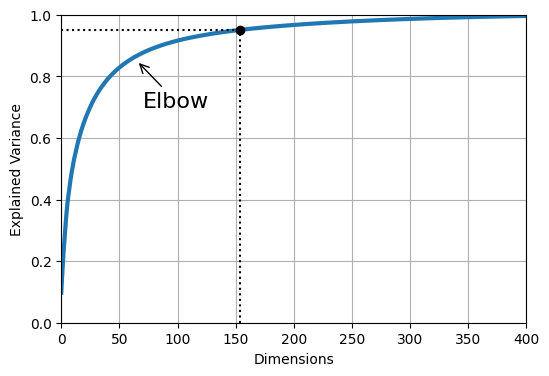

In [23]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [24]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [25]:
pca.n_components_

154

In [26]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557446

### 8.3.7 압축을 위한 PCA

압축된 데이터셋에 PCA 투영의 변환으 반대로 적용하여 되돌 릴 수 있음.<br>
투영에서 일정량의 정보를 잃어버렸기 때문에 이렇게 해도 원본 데이터셋을 얻을 수는 없음.

**재구성 오차**(reconstruction error): 원본 데이터와 재구성된 데이터 사이의 평균 제곱 거리

다음 코드는 MNIST 데이터셋을 154차원으로 압축하고 `inverse_transform()` 메서드를 사용해 784차원으로 복원

In [27]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [28]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

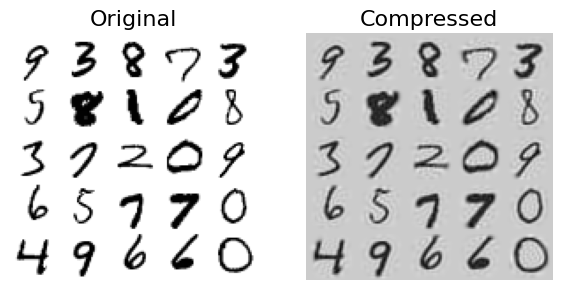

In [29]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

이미지 품질이 조금 손실되었지만 숫자 모양은 거의 온전한 상태임을 볼 수 있음.

원본의 차원 수로 되돌리는 PCA 역변환 공식<br>
$X_{recoverd} = X_{d-proj}W_{d}^{T}$

### 8.3.8 랜덤 PCA

**랜덤 PCA**: svd_solver 매개변수를 `randomized`로 지정하는 확률적 알고리즘. 이를 이용해 처음 d개의 주성분에 대한 근삿값을 빠르게 찾는다.<br>
시간 복잡도: $O(m \times d^{2}) + O(d^{3})$<br>
-> d가 n보다 많이 작을 때 완전 SVD보다 훨씬 빠름.

In [30]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

svd_solver의 기본값은 `auto`<br>
m이나 ndl 500보다 크고 d가 m이나 n의 80%보다 작으면 사이킷런은 자동으로 랜덤 PCA 알고리즘을 사용하거나 완전한 SVD 방식 사용<br>
사이킷런에서 완전 SVD 방식을 강제하려면 `svd_solver='full`

### 8.3.9 점진적 PCA

**점진적 PCA**(IPCA): 훈련 세트가 클 때 훈련 세트를 미니배치로 나눈 뒤 알고리즘에 주입하여 적용되는 방식

다음 코드는 MNIST 데이터셋을 100개의 미니배치로 나누고 사이킷런의 IncrementalPCA 클래스에 주입하여 154개 차원으로 줄임. 전체 훈련 세트를 사용하는 fit() 메서드가 아닌 `partial_fit()` 메서드를 미니배치마다 호출.

In [31]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # 책에는 없음
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [32]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

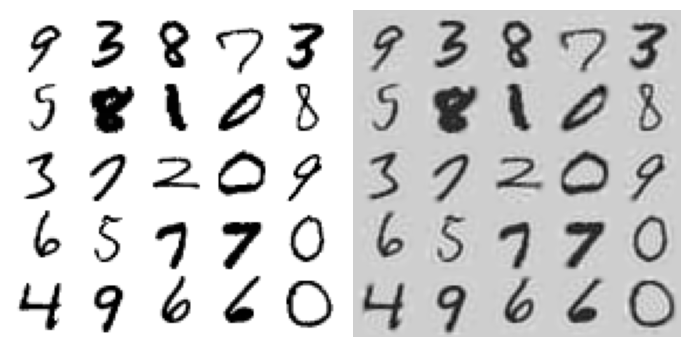

In [33]:
# 압축이 잘 되었는지 확인
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

`memmap()` 사용하여 하드 디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어있는 것처럼 다룸. 이는 필요할 때 데이터를 메모리에 적재.<br>
IncrementalPCA는 특정 순간에 배열의 일부만을 사용하기 때문에 메모리 부족 문제 해결 가능

In [34]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [35]:
del X_mm

In [36]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

## 8.4 커널 PCA

**커널 PCA**(kPCA): 차원 축소를 위한 복잡한 비선형 투형 수행. 투영 후 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때 유용.

다음 코드는 사이킷런의 KernelPCA를 사용해 RBF 커널로 kPCA 적용

In [41]:
from sklearn.datasets import make_swiss_roll
X, y = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [42]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### 8.4.1 커널 선택과 하이퍼파라미터 튜닝

kPCA는 비지도 학습이기 떄문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없음. 하지만 차원 축소는 종종 지도 학습의 전처리 단계로 활용되므로 **그리드 탐색**을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택할 수 있음.

다음 코드는 두 단계의 파이프라인을 만들어 kPCA를 사용해 차원을 2차원으로 축소하고 분류를 위해 로지스틱 회귀 적용, 그 후 파이프라인 마지막 단계에서 가장 높은 분류 정확도를 얻기 위해 GridSearchCV 사용하여 kPCA의 가장 좋은 커널과 gamma 파라미터 찾기.

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cha/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cha/miniforge3/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/cha/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1146, in fit
    check_classification_targets(y)
  File "/Users/cha/miniforge3/lib/python3.9/site-packages/sklearn/utils/multiclass.py", line 200, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'


**오류를 해결하지 못하였음**

In [ ]:
print(grid_search.best_params_)

완전한 비지도 학습 방법으로 가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터를 선택하는 방식도 있음. 하지만 재구성은 선형 PCA만큼 쉽지 않음.

커널 트릭 덕분에 해당 변환은 **특성 맵**(feature map)을 사용하여 훈련 세트를 무한 차원의 특성 공간에 매핑한 다음, 변환된 데이터셋을 선형 PCA를 사용해 2D로 투영한 것과 수학적으로 동일.

축소된 공간에 있는 샘플에 대해 선형 PCA를 역전시키면 재구성된 데이터 포인트는 원본 공간이 아닌 특성 공간에 놓임. 이 특성 공간은 무한 차원이기 때문에 재구성된 포인트를 계산할 수 없고 재구성에 따른 실제 error를 계산할 수 없음.

**재구성 원상**(pre-image): 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트를 찾는 것.<br>
원상을 얻게 되면 원본 샘플과의 제곱 거리를 측정 가능 -> 재구성 원상의 오차를 최소화하는 커널과 하이퍼파라미터 선택 가능

재구성 하는 방법<br>
: 투영된 샘플을 훈련 세트로, 원본 샘플을 타깃으로 하는 지도 학습 회귀 모델을 훈련<br>
-> 사이킷런에서는 `fit_inverse_transform=True`로 지정하면 자동으로 수행

In [46]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [47]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576613

이렇게 되었을 시 재구성 원상 오차를 최소화하는 커널과 하이퍼파라미터를 찾기 위해 교차 검증으로 그리드 탐색 사용 가능

## 8.5 LLE

**지역 선형 임베딩**(locally linear embedding)(LLE): 또 다른 강력한 **비선형 차원 축소**(nonlinear dimensionality)(NLDR) 기술, 투영에 의존하지 않는 매니폴드 학습<br>
1. 먼저 각 훈련 샘플이 가장 가까운 이웃(closest neighbor)(c.n.)에 얼마나 선형적으로 연관되어 있는지 측정한다.
2. 그런 다음 국부적인 관계가 가장 잘 보존되는 훈련 세트의 저차원 표현을 찾는다.

=> 이는 특히 잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는 데 잘 작동

다음 코드는사이킷런의 LocallyLinearEmbedding 사용하여 스위스롤 펼침

In [48]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

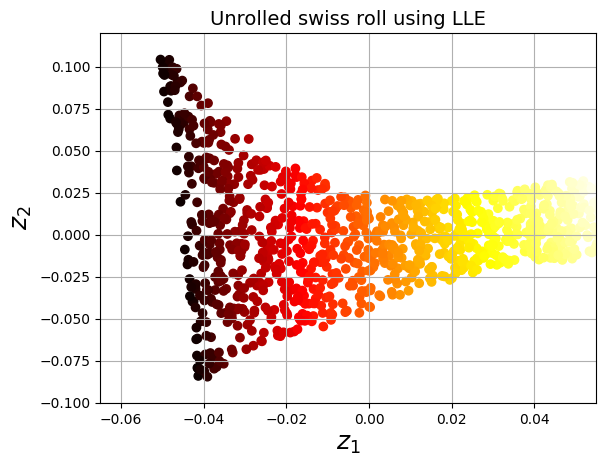

In [49]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

=> 스위스 롤이 완전히 펼쳐졌고 지역적으로는 샘플 간 거리가 잘 보존되어있음. 하지만 샘플 간 거리가 잘 유지되어있지 않음. (펼쳐진 스위스 롤의 오른쪽은 압축되어있고 왼쪽은 확장되어 있음)

#### LLE 구현 시간 복잡도
- k개의 가장 가까운 이웃을 찾는데 $O(mlog(m)nlog(k)$
- 가중치 최적화에 $O(mnk^{3})$
- 저차원 표현을 만드는데 $O(dm^{2})$<br>
=> 마지막 항의 $m^2$ 때문에 대량의 데이터셋에 적용하기는 어려움.

## 8.6 다른 차원 축소 기법

- **랜덤 투영**(random projection)<br>
랜덤한 선형 투영을 사용해 데이터를 저차원 공간으로 투영. 실제로 거리를 잘 보존하는 것으로 밝혀짐. 차원 축소 품질은 샘플 수와 목표 차원수에 따라 다름. 하지만 초기 차원수에는 의존적이지 않음.
<br>
<br>
- **다차원 스케일링**(multidimensional scaling)(MDS)<br>
샘플 간 거리를 보존하며 차원을 축소

In [50]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

- **Isomap**<br>
각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프 생성. 그런 다음 샘플 간의 지오데식 거리(geodesic distance)를 유지하며 차원 축소

In [51]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

- **t-SNE**(t-distributed stochastic neighbor embedding)<br>
비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원을 축소. 주로 시각화에 많이 사용되며 특히 고차원 공간에 잇는 샘플의 군집을 시각화할 때 사용.

In [52]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

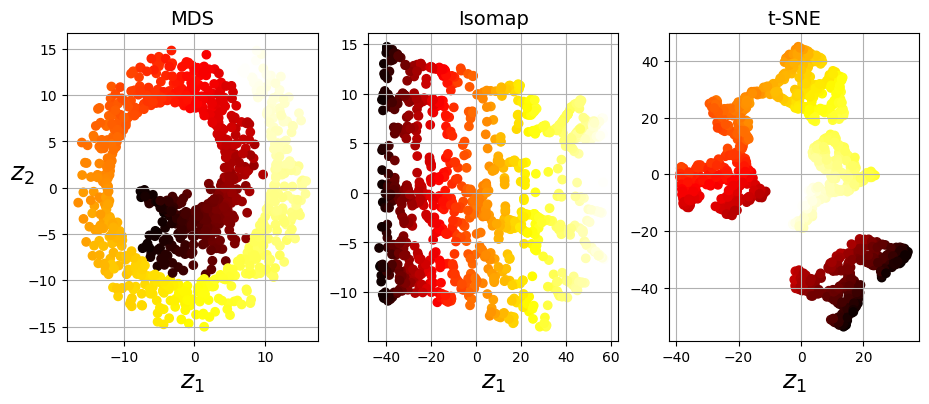

In [54]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

- **선형 판별 분석**(linear discriminant analysis)(LDA)<br>
분류 알고리즘. 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습. 해당 축은 데이터가 투영되는 초평면을 정의하는데에 사용 가능. <br>
장점으로는 투영을 통해 가능한 한 클래스를 멀리 떨어지게 유지시키므로 SVM 분류기 같은 다른 분류 알고리즘을 적용하기 전에 차원을 축소시키는 데 좋음

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)